In [444]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [445]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy as sc
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_101,
    FILE_PATH_CASE_101_HFM_T,
    FILE_PATH_CASE_101_HFM_T_OBS,
    FILE_PATH_CASE_101_HFM_Z,
    FILE_PATH_TEST_SET_CASE_101,
    RHEOLOGY_DATA_CASE_101_PATH
)

from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    extract_time_series_from_depth_data_for_given_variables,
    get_herschel_bulkley_parameters_from_rheology_file,
    get_testing_dataset_from_field_data
)

sns.set_theme()

In [447]:
# Loading files
sensor_data = pd.read_pickle(FILE_PATH_CASE_101)
# Extracting the dates to consider
tstamp_min = '2020-07-23 02:45:00+00:00'
tstamp_max = '2020-07-25 02:30:00+00:00'
sensor_data = sensor_data.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data = sensor_data.iloc[1:] 
hfm_data_t = pd.read_pickle(FILE_PATH_CASE_101_HFM_T)
hfm_data_t_obs = pd.read_pickle(FILE_PATH_CASE_101_HFM_T_OBS)
hfm_data_z = pd.read_pickle(FILE_PATH_CASE_101_HFM_Z)


In [448]:
# Getting the indices for the model data right
start_date = '2020-08-17 12:00:10+00:00'
date_range = pd.date_range(start = start_date, periods = len(hfm_data_t), freq='10s')
hfm_data_t.index = date_range
# hfm_data_case_102_t_obs.index = date_range
hfm_data_t.head()
hfm_data_t.columns

Index(['Rate_in', 'SPP', 'ECD_bot', 'ECD_shoe', 'P_choke', 'FrontFluid2',
       'FrontFluid3', 'FrontFluid4', 'FrontFluid5', 'FrontFluid6', 'totVolInj',
       'totStrokes', 'totVolOut', 'pitVol', 'WHP', 'volRateOut', 'dsGap',
       'BHP', 'T_bot', 'T_top', 'mdBit', 'ecdAtPos', 'pAtPos', 'TAtPos',
       'dsRpm', 'rop', 'xFactor', 'kFactor', 'yCalc', 'yCalcAvg', 'yMeas',
       'Pxy', 'Pyy', 'Pa', 'Gel1', 'Gel2', 'Gel3', 'Gel4', 'Gel5', 'ShieldBHA',
       'ShieldAnn', 'ShieldRiser', 'CtrBHA', 'CtrAnn', 'CtrRiser',
       'CutConsBHA', 'CutConsAnn', 'CutConsRiser', 'ReynBHA', 'ReynAnn',
       'ReynRiser', 'TaylBHA', 'TaylAnn', 'TaylRiser', 'RouseBHA', 'RouseAnn',
       'RouseRiser', 'voidShoe', 'voidAtBha', 'cutSt', 'vDev', 'pDev',
       'mTotMud', 'mFreeGas', 'mDGas', 'qLoss', 'mLost', 'XFactor',
       'DSXFactor', 'DensityIn', 'DensityOut', 'incl'],
      dtype='object')

In [449]:
print(len(sensor_data), len(hfm_data_t))
sensor_data.head()

17190 17190


,ASMDEP1-T,ASMECD1-T,ASMDEP2-T,ASMECD2-T,ASMDEP3-T,ASMDOFF-T,DHT001 Temp PCB Mean,ASMTVD1-T,ASMTVD2-T,ASMTVD3-T,...,RPMPerStand,TqavPerStand,WOBRotPerStand,WOBPerStand,TqavPerStandRot,FlowPerStand,RPMPerStandRot,RDGDTVSS-Relog,AllSlidingRopPerStand,TqavPerStandSl
TIME,,,,,,,,,,,,,,,,,,,,,
2020-07-23 02:45:10+00:00,272.810000,1.332205,-613.861429,1.451468,-1385.245000,-184.820007,16.0,272.789998,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:20+00:00,272.810000,1.332205,-613.850000,1.451468,-1385.230000,-184.820007,16.0,272.789998,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:30+00:00,272.823333,1.332205,-613.846667,1.451468,-1385.225000,-184.820007,16.0,272.803324,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:40+00:00,272.842500,1.332205,-613.825000,1.451468,-1385.206667,-184.820007,16.0,272.822495,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43
2020-07-23 02:45:50+00:00,272.862500,1.332205,-613.803333,1.451468,-1385.185000,-184.820007,16.0,272.842499,0.36,0.45,...,12.32,21316.99,4906.12,4906.12,21316.99,0.04,12.32,80.0,52.33,46742.43


In [450]:

# sensor_data_case_102, hfm_data_case_102_t = get_active_drilling_data(sensor_data_case_102, hfm_data_case_102_t, include_rop_zeros=True)
# Wait to get obs data. Not sure if it is necassary
# hfm_data_case_102_t_obs = hfm_data_case_102_t_obs.loc[hfm_data_case_102_t.index]

In [451]:
print(len(sensor_data), len(hfm_data_t),len(hfm_data_t_obs))
hfm_data_t.index = sensor_data.index
hfm_data_t_obs.index = sensor_data.index

17190 17190 17190


In [452]:
# depth_data_columns = hfm_data_z.columns
# depth_data_columns


In [453]:
# First element of touple is the depth data file
depth_data = hfm_data_z[0] 
#Second element contain the columns
depth_data_columns = hfm_data_z[1]


In [454]:
print(depth_data_columns)
print(len(depth_data))

['time', 'loc', 'mdOut', 'mdIn', 'pOut/pBar', 'ecdOut', 'dpf', 'reyn', 'tayl', 'shieldsNum', 'rouseNum', 'avgDensity', 'mudMass', 'cuttMass', 'vL', 'vG', 'vC', 'TOut']
18


In [455]:
inclination = np.arccos(hfm_data_t_obs["TvdAtPpos1"].diff() /  hfm_data_t["mdBit"].diff()) * 180 / np.pi
asm_sensor_2 = sensor_data["ASMDEP2-T"]

c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [456]:
values_for_position = extract_time_series_from_depth_data_for_given_variables(depth_data=depth_data, position_for_time_series=asm_sensor_2.values,columns=depth_data_columns)

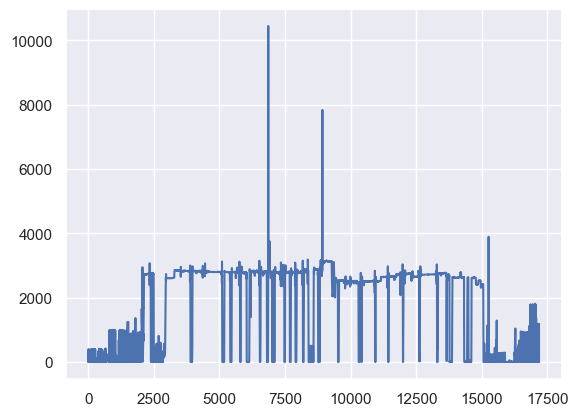

In [457]:
plt.plot(values_for_position["reyn"])
plt.show()

In [458]:
# m / s^2
gravitational_constant = 9.80
# m
DH = 0.06985
# m
charecteristic_length = 0
liquid_velocities = values_for_position["vL"]
pressure_gradient = values_for_position["dpf"]
# Unsure if this densisty value is the correct one
fluid_density = values_for_position["avgDensity"]
pressure = values_for_position["pOut/pBar"]
# Value blows up when there is little flow. Don't think this will be a problem during steady state conditions
fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)
values_for_position["Friction factor"] = fanning


C:\Users\thomaswi\AppData\Local\Temp\ipykernel_21512\1559830564.py:13: RuntimeWarning: divide by zero encountered in divide
  fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)


In [459]:
indices = [2200,4200,7600]


In [460]:
values_for_position_df = pd.DataFrame(values_for_position)
values_for_position_df.index = sensor_data.index
drilling_sensor_data, values_for_position_df = get_active_drilling_data(sensor_data, sim_df=values_for_position_df ,include_rop_zeros=True)

10608


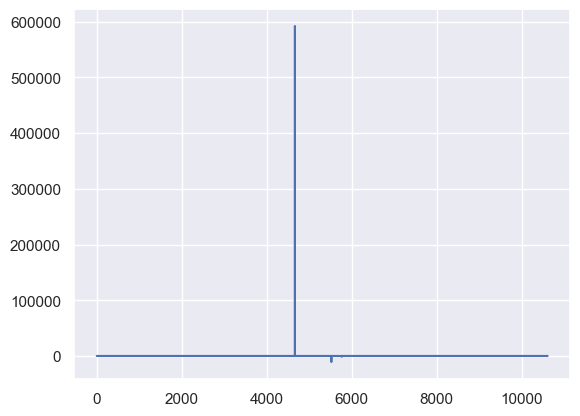

In [461]:
print(len(drilling_sensor_data))
plt.plot(values_for_position_df["Friction factor"].values)

In [462]:
hb_parameters = get_herschel_bulkley_parameters_from_rheology_file(RHEOLOGY_DATA_CASE_101_PATH) 
hb_parameters.head(11)    


,Temperature,Pressure,Consistency index (K),Yield stress (tau_y),Flow behaviour index (n)
0,50.0,1.0,0.958735,0.044013,0.873375
1,50.0,103.0,1.185470,0.027074,0.960688
2,70.0,138.0,1.414590,0.037418,0.895384
3,70.0,172.0,1.410800,0.039181,0.896108
4,100.0,207.0,1.718600,0.049447,0.850131
5,100.0,241.0,1.653350,0.038693,0.893673
6,120.0,276.0,1.592610,0.048652,0.845525
7,120.0,310.0,1.544660,0.035205,0.895552
8,120.0,345.0,1.407300,0.034718,0.887522
9,120.0,414.0,1.391150,0.033585,0.901169


In [463]:
values_for_position_df.head()
yield_stress = []
consistency_index = []
flow_behaviour_index = []
temperature_regions = values_for_position_df["TOut"].apply(lambda x: 1 if x > 60 else 0)
hb_parameters_for_case = np.array([hb_parameters.loc[2] if t_region == 1 else hb_parameters.loc[1] for t_region in temperature_regions])

print('Min and max temp: ',values_for_position_df["TOut"].min(),values_for_position_df["TOut"].max())
print('Min and max pressure: ',values_for_position_df["pOut/pBar"].min(),values_for_position_df["pOut/pBar"].max()) 

print(len(liquid_velocities))
print(len(hb_parameters_for_case))
    

Min and max temp:  57.115062554225226 75.0054964028777
Min and max pressure:  219.47399336283186 269.0726840066408
17190
10608


In [464]:
values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])
values_for_position_df["reyn/tayl"] = values_for_position_df["reyn"] / values_for_position_df["tayl"]
values_for_position_df["reyn by bingham"] = values_for_position_df["reyn"] * values_for_position_df["Bingham number"]
values_for_position_df["tayl by bingham"] = values_for_position_df["tayl"] * values_for_position_df["Bingham number"]
values_for_position_df["reyn/friction fac"] = values_for_position_df["reyn"] / values_for_position_df["Friction factor"]

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_21512\725129836.py:1: RuntimeWarning: invalid value encountered in power
  values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])


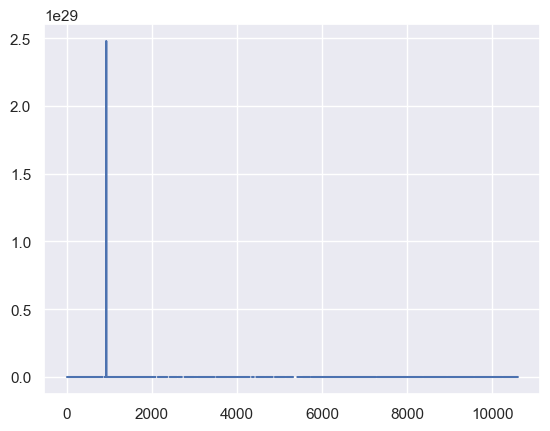

In [465]:
plt.plot(values_for_position_df["reyn/tayl"].values)

In [466]:
# The annulus is assumed fully eccentric when inclination is 90 degrees
# Inclination can take values of 45, 60 and 90 degrees
# Plot indicates that the inclination is mostly close to or is 90 degrees
variables_1 = ["reyn","tayl","Bingham number","Friction factor"]
variables_2 = ["reyn/tayl", "tayl by bingham", "reyn/friction fac"]
variables = variables_2
df_of_variables_at_points = get_testing_dataset_from_field_data(df=values_for_position_df,variables=variables,indices=indices,ecccentricty=None,inclination=None, fluid_type = None)


In [467]:
# Order is important due to the machine learning algorithms
df_of_variables_at_points = df_of_variables_at_points[variables]
df_of_variables_at_points.head()

,reyn/tayl,tayl by bingham,reyn/friction fac
2200,2.603014,1.203962,444110.836619
4200,1.410868,2.181072,411358.192780
7600,1.339284,2.164564,359249.169751


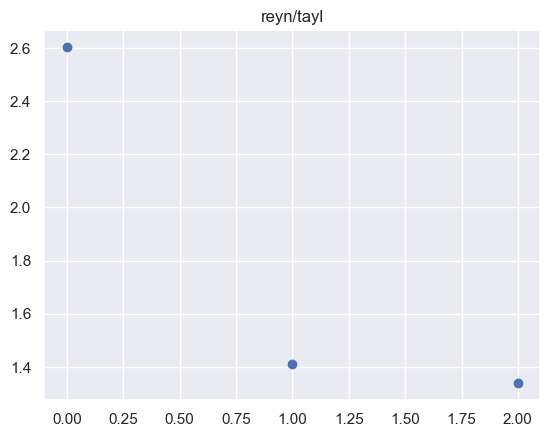

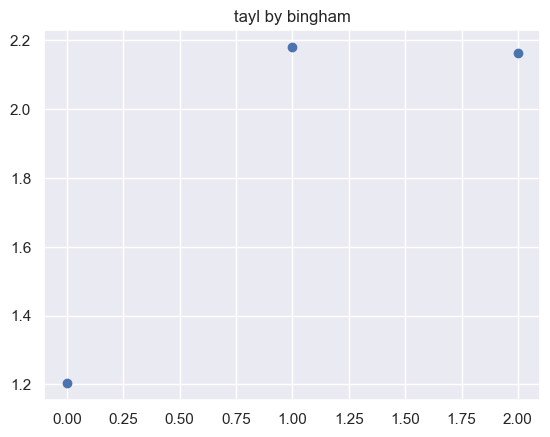

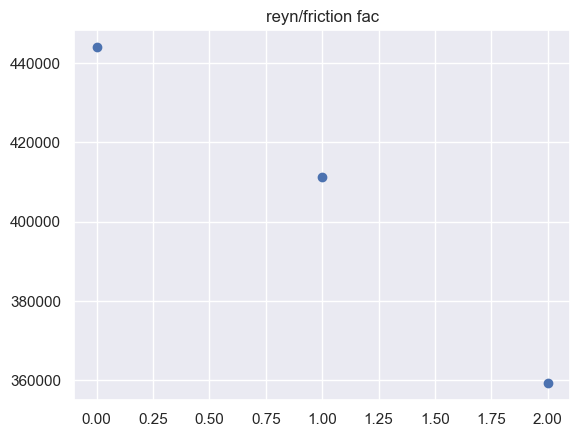

In [468]:
x = np.arange(0,len(df_of_variables_at_points),1)
for key,value in df_of_variables_at_points.items():
    plt.title(f'{key}')
    plt.scatter(x,value.values)
    plt.show()
    

In [469]:
df_of_variables_at_points.to_pickle(FILE_PATH_TEST_SET_CASE_101)